# Image Segmentation and effects of Skip connections in UNet.

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

"""
Forked from :
https://www.kaggle.com/code/dhvananrangrej/image-segmentation-with-unet-pytorch/notebook.
"""

## 1. Preparation

In [77]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### 2. Configure data locations

In [78]:
data_dir = os.path.join("/home2","rkada","cityscapes_data", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


### 3. Analyze the data

/home2/rkada/cityscapes_data/cityscapes_data/train/936.jpg


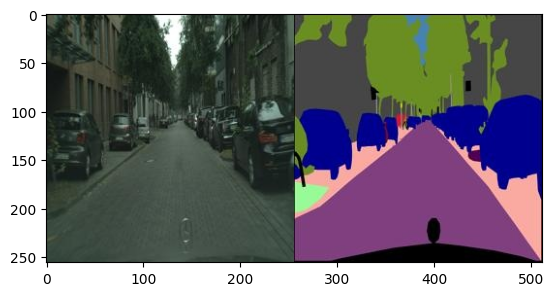

In [79]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 4. Extract Image and Labels
The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [80]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

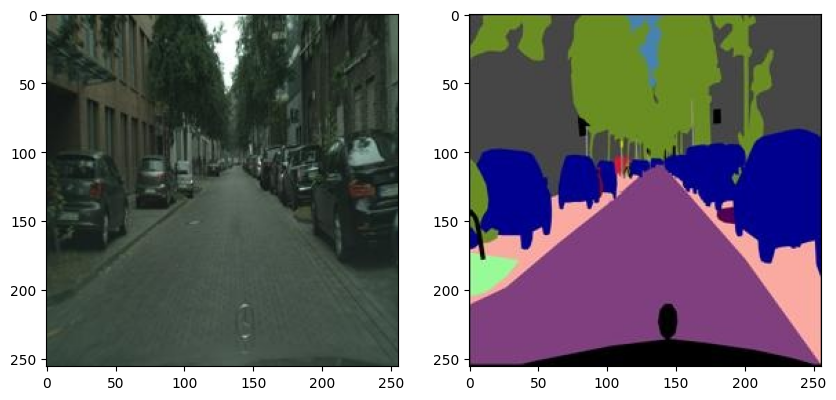

In [81]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

### 5. Define Labels
We use K-means clustering to segregate the objects of different colors and assign them class labels.

In [82]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [83]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/home2/rkada/miniconda3/envs/deepfont/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

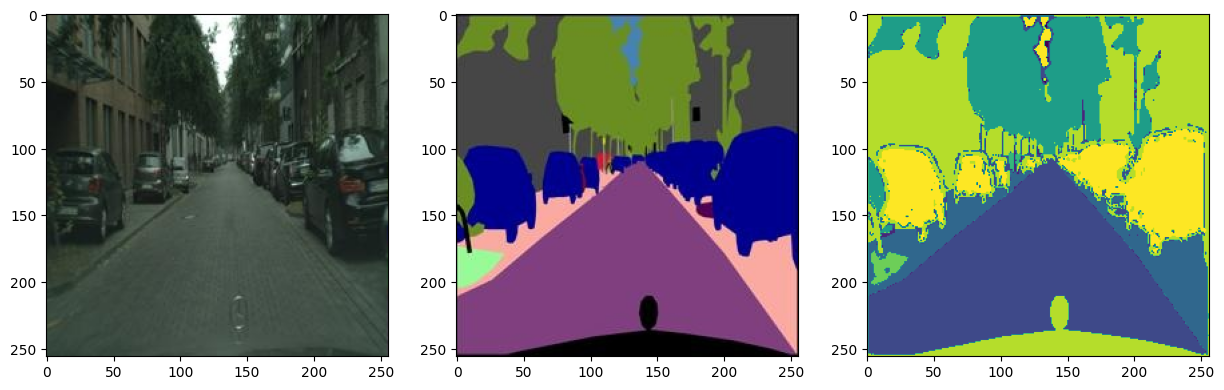

In [84]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [85]:
label_class

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       ...,
       [8, 2, 2, ..., 2, 3, 8],
       [8, 8, 8, ..., 8, 2, 8],
       [8, 8, 8, ..., 8, 8, 8]], dtype=int32)

In [86]:
np.unique(label_class)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

### 6. Define Dataset

In [87]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [88]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [89]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model

In [90]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [91]:
model = UNet(num_classes=num_classes)

In [92]:
data_loader = DataLoader(dataset, batch_size = 16)
print(len(dataset), len(data_loader))

for X,Y in data_loader:
    print(X.shape, Y.shape)
    break

2975 186
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [93]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])


### Train the model

In [99]:
batch_size = 16

epochs = 2
lr = 0.01

In [100]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [101]:
model = UNet(num_classes = num_classes).to(device)

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [103]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

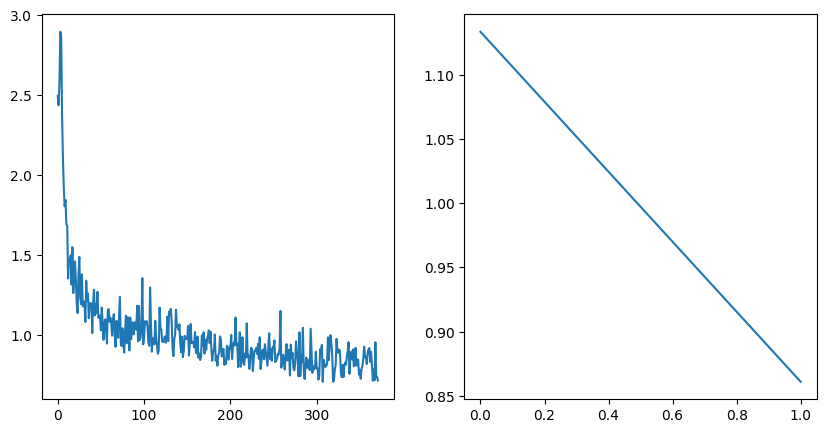

In [104]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

#### Trained on 2 epochs.

In [105]:
model_name = "/scratch/U-Net-rkada.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [106]:
model_path = "/scratch/U-Net-rkada.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [107]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [108]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [109]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

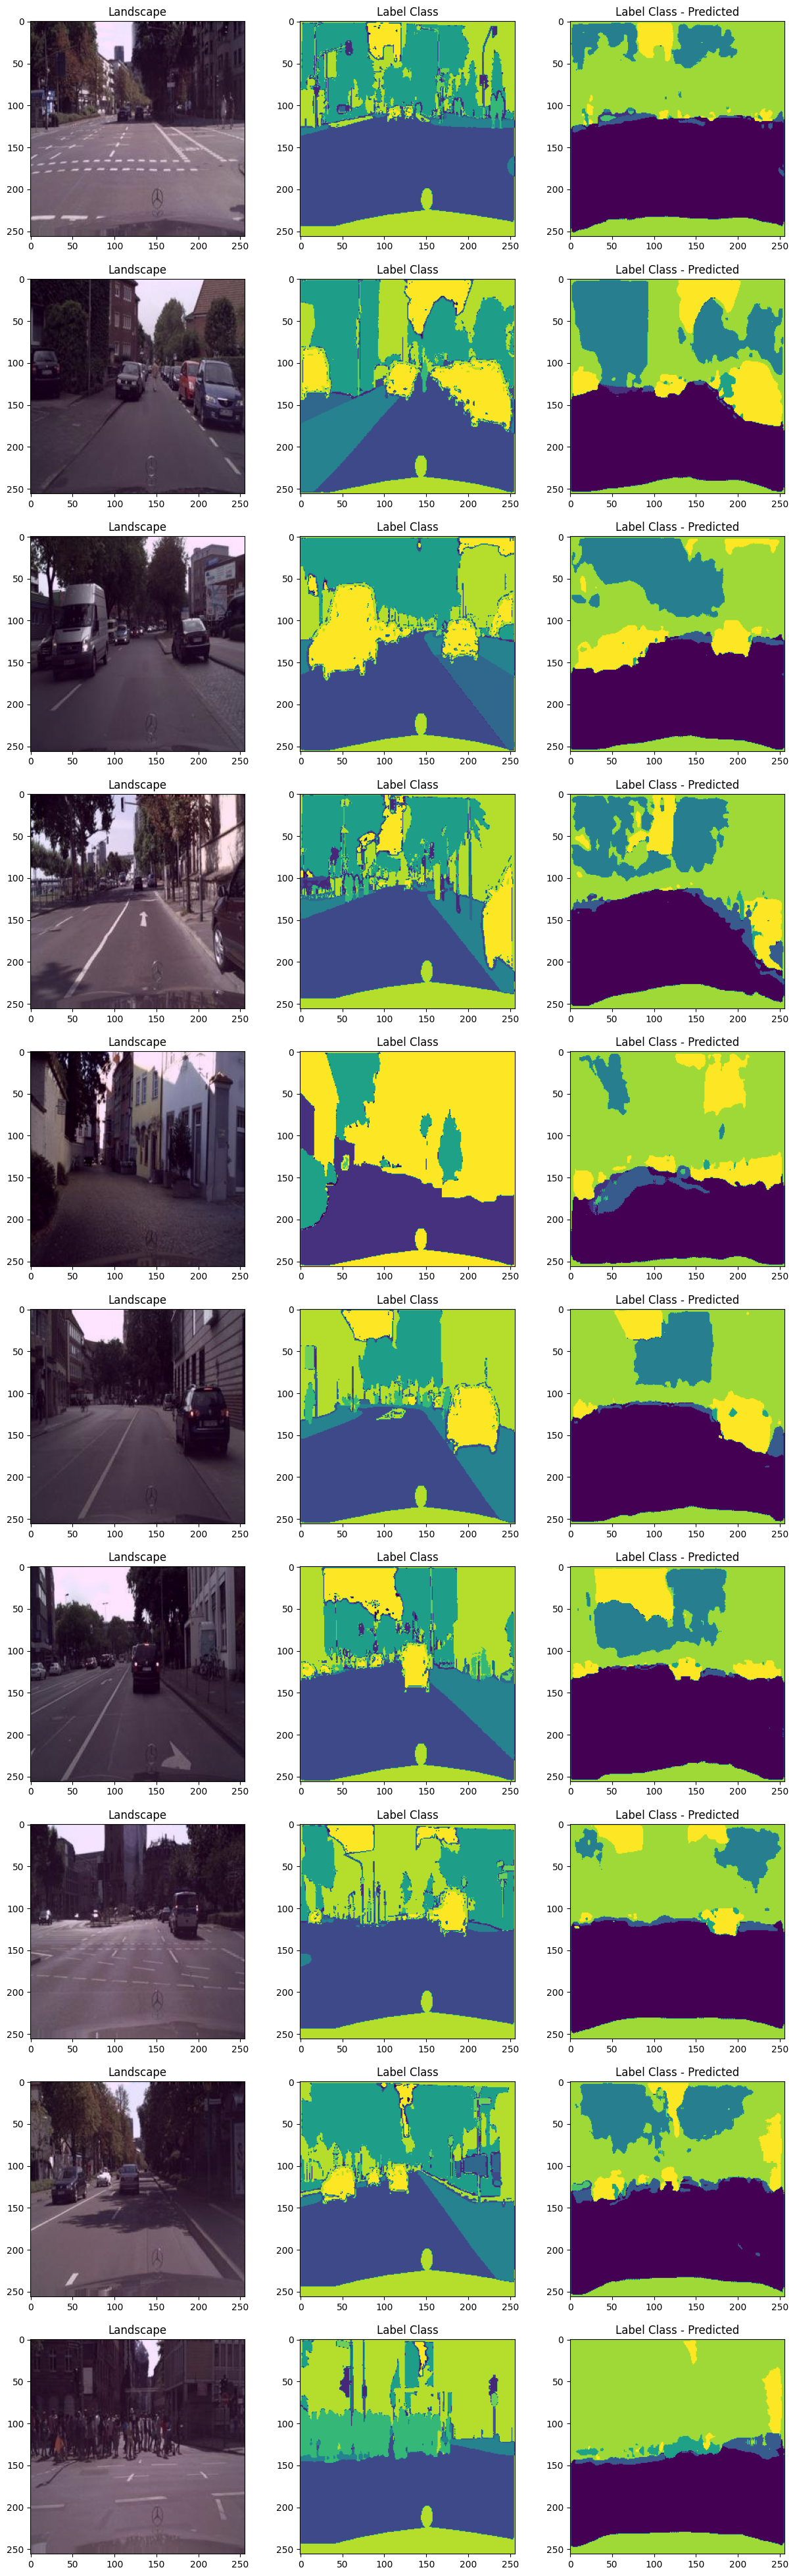

In [110]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores1 = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores1.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [111]:
print(sum(iou_scores1) / len(iou_scores1))

0.9986312866210938


## 2. Remove Skip Connections

### 10. Remove Skip connections

In [112]:
class UNet_skipNot(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet_skipNot, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(contracting_41_out) # [-1, 512, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(contracting_31_out) # [-1, 256, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 128, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

### Train the model

In [113]:
batch_size = 16

epochs = 2
lr = 0.01

In [114]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [115]:
model = UNet_skipNot(num_classes = num_classes).to(device)

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [117]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

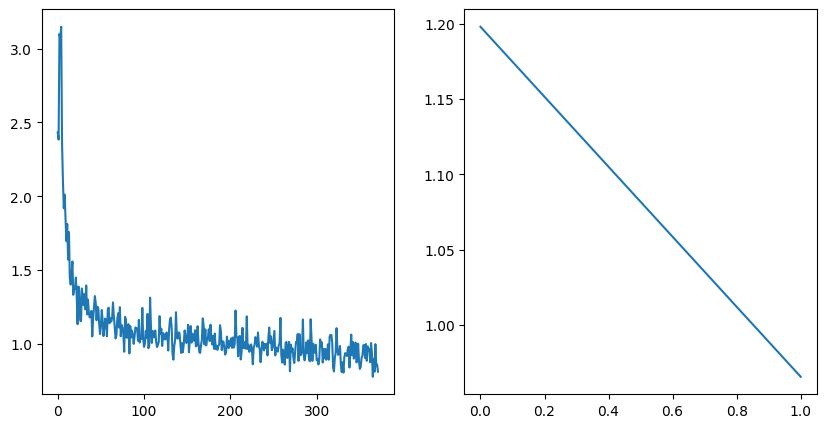

In [118]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

### Trained on 2 epochs

In [119]:
model_name = "/scratch/U-Net-rkada-withoutSkip.pth"
torch.save(model.state_dict(), model_name)

### Prediction on U-NET without Skip

In [120]:
model_path = "/scratch/U-Net-rkada-withoutSkip.pth"
model_ = UNet_skipNot(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [121]:
model_path = "/scratch/U-Net-rkada.pth"
model_1 = UNet(num_classes=num_classes).to(device)
model_1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [122]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [123]:
model_1 = UNet(num_classes=num_classes).to(device)
model_1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [124]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
Y_pred1 = model_1(X)
print(Y_pred.shape)
print(Y_pred1.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
Y_pred1 = torch.argmax(Y_pred1, dim=1)
print(Y_pred.shape)
print(Y_pred1.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])
torch.Size([10, 256, 256])


In [125]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

65536
65536
65536
65536
65536
65536
65536
65536
65536
65536


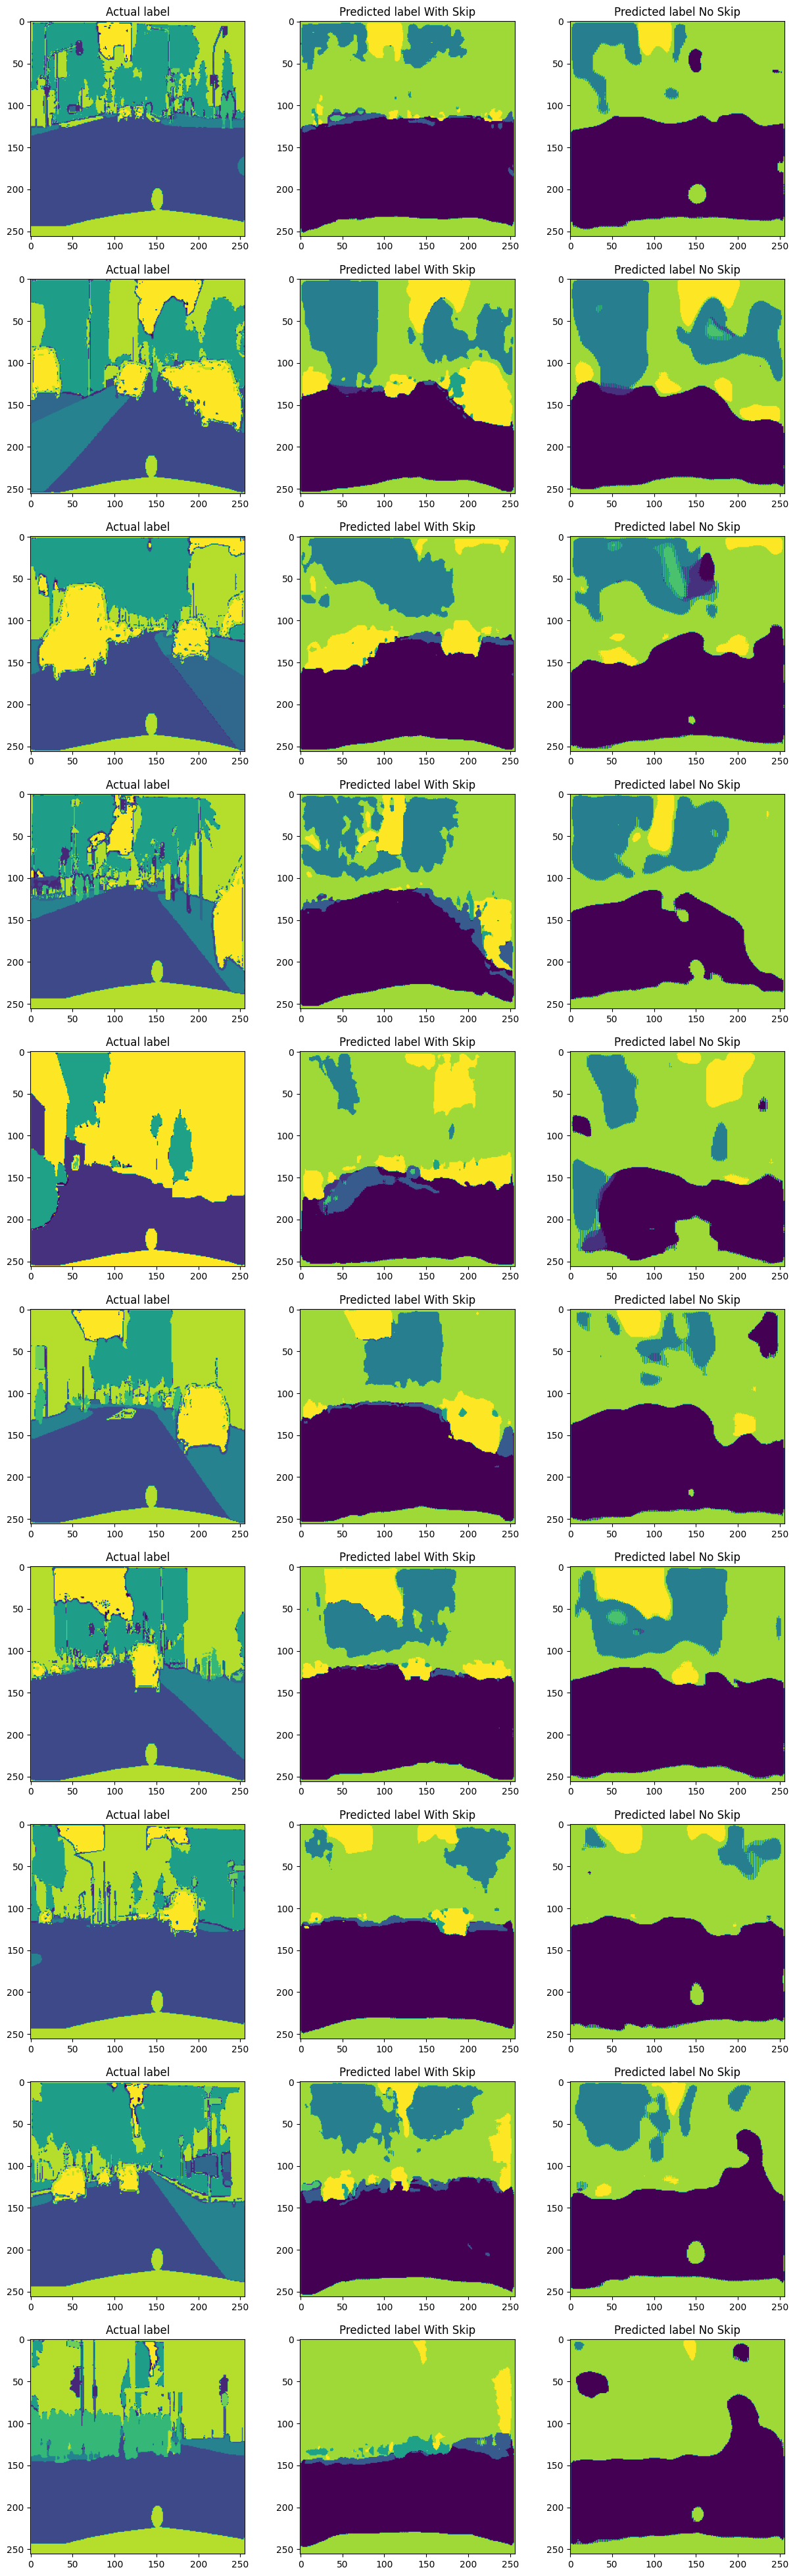

In [130]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class_predicted1 = Y_pred1[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    print(np.sum(union))
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(label_class)
    axes[i, 0].set_title("Actual label")
    axes[i, 1].imshow(label_class_predicted1)
    axes[i, 1].set_title("Predicted label With Skip")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Predicted label No Skip")

In [131]:
print(sum(iou_scores) / len(iou_scores))

0.9986312866210938


#### Importance of skip connections : 
Above are the results and comparisions for the model with and without skip connections. You can clearly see that without skip connection the model tries to smoothen the boundaries of the segmentation masks and make them simpler, which is not true in the actual cityscapes segmentation dataset, we need some sharp edges in segmentation mask and the skip connections allow the gradients to propogate fully throughout the network to understand the image.

## 3. Metric

#### Issue with their IoU : 
Their IoU basically boils down to calculating the fraction of matches in a n x n matrix. So, by doing np.logical_or() since the labels are always >=0, if either of them >0 it returns true, so we can assume that everytime we get n x n as the sum of (union). [Pls note : There is a mistake in their IoU because if we get both label and prediction as 0 at a certain coordinate we get a False, and that would not make sense in a union operation.]

In the intersection operation, they just find the matches which is a problem, [here also 0 and 0 returns False] . But the above is the described issue in their Union Operation.

Illustration:

In [3]:
np.logical_or(0,0)

False

In [134]:
np.logical_and(0,0)

False

Thus, it does not add up in sum(union) but it logically should add.

#### Our refined metric

In [146]:
def mIoU(predicted_label,actual_label,num_classes=10):
    predicted_label_corrected =  predicted_label+1
    actual_label_corrected =  actual_label+1

    iou_score = 0
    for cls in range(1,num_classes+1):
        mask = np.full_like(predicted_label_corrected,cls)
        intersection_mask = np.logical_and(predicted_label_corrected==cls,actual_label_corrected==cls)
        union_mask = np.logical_or(np.logical_and(predicted_label_corrected,mask),np.logical_and(actual_label_corrected,mask))
        iou_score += np.sum(intersection_mask)/np.sum(union_mask)
    iou_score = iou_score/num_classes
    return iou_score

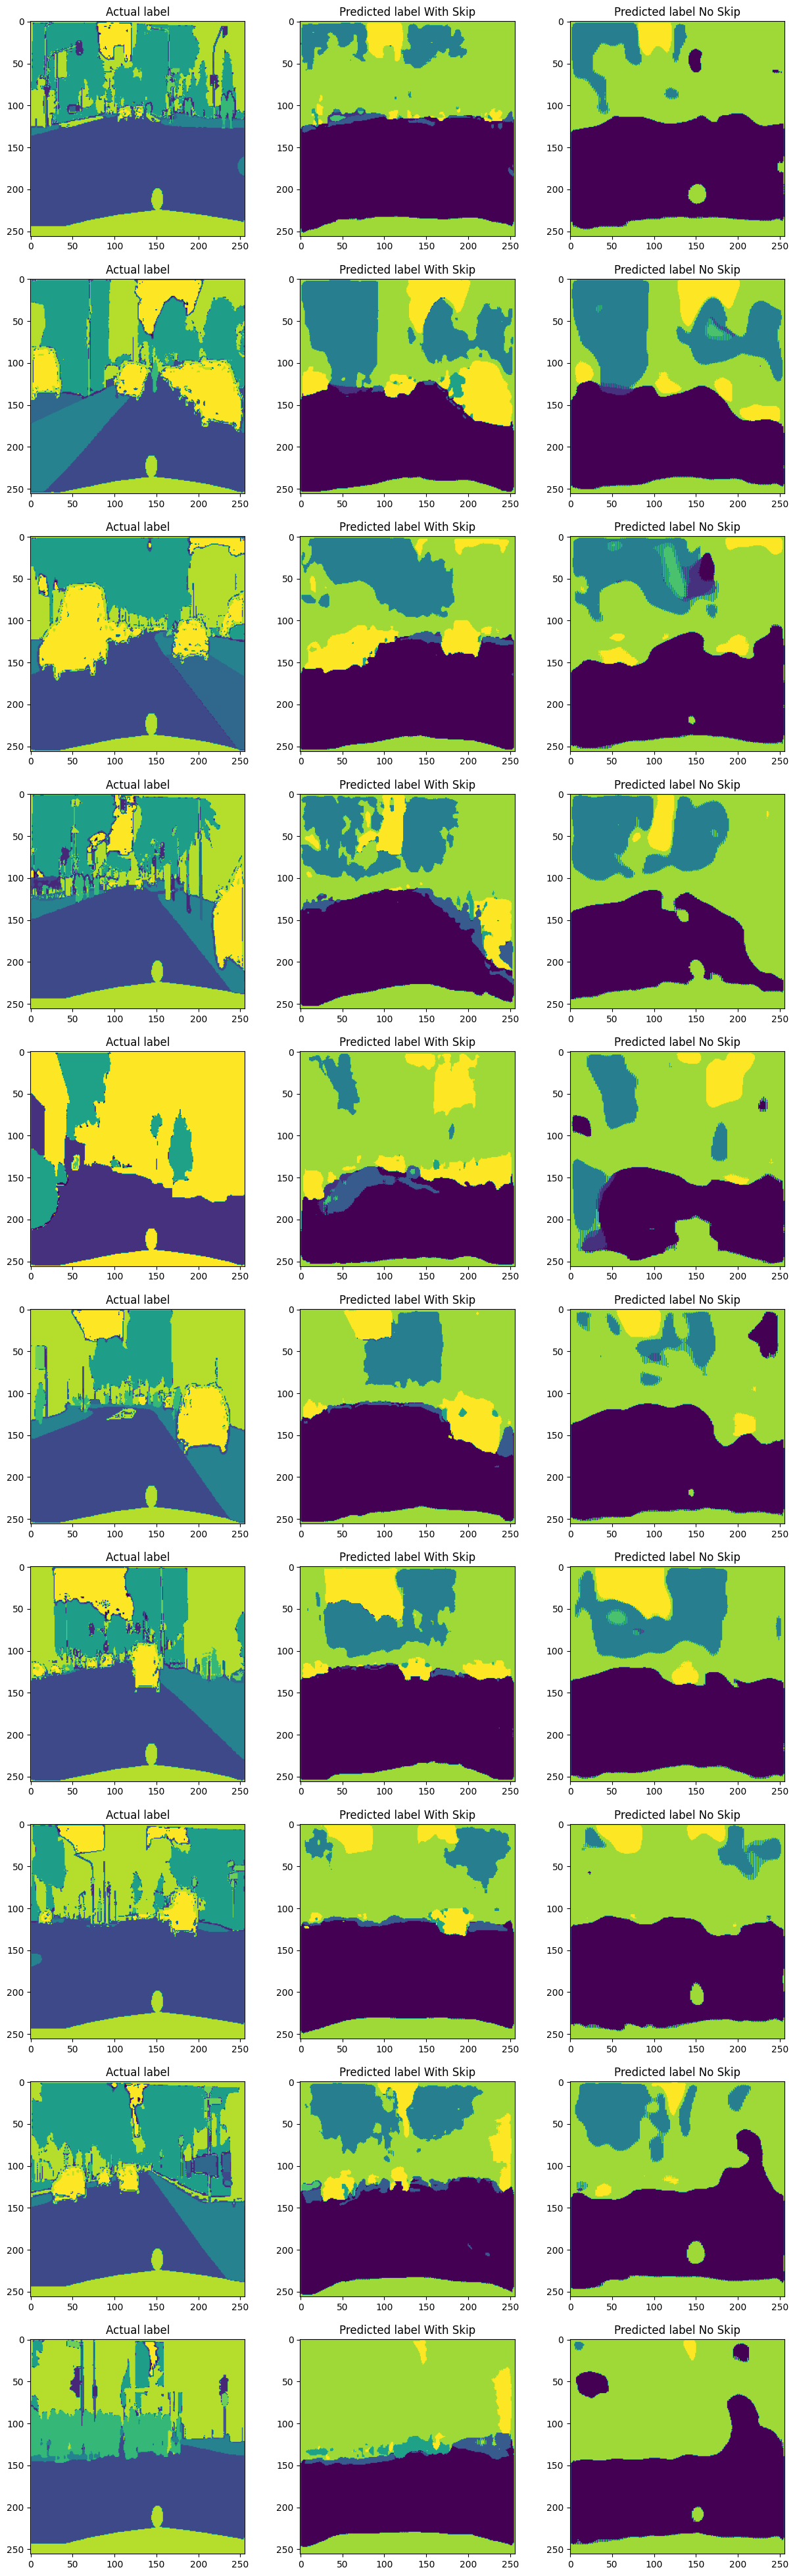

In [147]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores1 = []
iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class_predicted1 = Y_pred1[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    
    iou_scores1.append(mIoU(label_class_predicted1,label_class))
    iou_scores.append(mIoU(label_class_predicted,label_class))

    axes[i, 0].imshow(label_class)
    axes[i, 0].set_title("Actual label")
    axes[i, 1].imshow(label_class_predicted1)
    axes[i, 1].set_title("Predicted label With Skip")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Predicted label No Skip")

#### Qualitative Comparision of our refined mIoU

In [148]:
print("Without skip connections : ",sum(iou_scores) / len(iou_scores))
print("With skip connections : ",sum(iou_scores1) / len(iou_scores1))

Without skip connections :  0.07061126708984375
With skip connections :  0.07414779663085938


### Thus this metric differentiates between skip and without skip connections results : 
1. With skip connections, it gives 0.074 mIoU
2. Without skip connections , it gives 0.070 mIoU

#### Thus, in further training the skip connections will help !

In [1]:
import torch
import torchvision
import clip

## Setup

In [2]:
RN50_IMAGENET = torchvision.models.resnet50(weights='IMAGENET1K_V1')

In [3]:
!pip install openai-clip

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
# load clip RN50 model
RESNET50_CLIP = clip.load(name='RN50')

In [6]:
print(RESNET50_CLIP)

(CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
    

In [7]:
clip_rn50 = dict(RESNET50_CLIP[0].named_children())
model_arch_clip = clip_rn50['visual']

In [8]:
model_arch_clip # CLIP VISUAL ENCODER BACKBONE RN50

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

In [9]:
overview_rn50_clip = dict(model_arch_clip.named_children())

In [10]:
RN50_IMAGENET # IMAGENET PRETRAINED RESNET50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
overview_rn50_imagenet = dict(RN50_IMAGENET.named_children())

In [12]:
print(list(overview_rn50_imagenet))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [13]:
print(list(overview_rn50_clip))

['conv1', 'bn1', 'relu1', 'conv2', 'bn2', 'relu2', 'conv3', 'bn3', 'relu3', 'avgpool', 'layer1', 'layer2', 'layer3', 'layer4', 'attnpool']


### The difference in RN50 (IMAGENET) vs RN50 (CLIP)

1. The CLIP base RN50 backbone uses three (Conv, bn, relu) layers before feeding it into layers blocks of resnet50. Also there seems to be a difference in the architecture of the (Conv, bn, relu). The ResNet50 (IMAGENET) just uses one (Conv, bn, relu) layer before feeding into the blocks like layer1,layer2,layer3 and layer4.
2. It is important to note that CLIP based ResNet50 uses an attention module at the end of the architecture, which is a new change not present in ResNet 50 (IMAGENET)
3. We also note that the output is of 1000 dim in original ResNet50 (IMAGENET) but the output in clip based RN50 is of 1024 dim after passing through the attention pool module.

### 2. Understanding IMAGENET DATASET (ILSVRC)
(i) Label Hierarchy: The ImageNet dataset uses a hierarchical structure for its labels. It follows the WordNet hierarchy, which organizes words into sets of cognitive synonyms called synsets. These synsets are connected by hypernym/hyponym relationships, where a hypernym is a more general concept and a hyponym is a more specific instance of that concept. For example, "animal" is a hypernym of "dog", and "dog" is a hyponym of "animal".

(ii) Synset: A synset, short for "synonym set", is a group of words that are synonymous (or closely related) in meaning. In the context of ImageNet, each synset represents a category of objects or concepts. For instance, the synset "dog" might include images of various dog breeds, while the synset "car" might include images of different types of automobiles.

(iii) Grouping Objects based on Synsets and Visual Recognition: While grouping objects based on synsets provides a structured way to organize and label data, it can lead to challenges in visual recognition. This is because objects within the same synset can vary significantly in appearance due to factors like viewpoint, pose, lighting conditions, occlusion, and intra-class variation (variations within the same category). These variations can make it difficult for computer vision models to accurately classify objects based solely on their visual features.

(iv) Types of Visual Differences within the Same Synset:

1. Viewpoint Variation: Objects within the same synset may appear different due to variations in viewpoint. For example, a dog viewed from the side may look different from the same dog viewed from the front.

2. Intra-class Variation: Objects in the same category can have diverse appearances. For instance, different breeds of dogs may have distinct fur patterns, sizes, and colors.

3. Environmental Factors: Objects can appear different due to the context or environment in which they are captured. For example, a car photographed on a city street may look different from the same car photographed in a rural setting due to background clutter and lighting conditions.

In [21]:
def read_txt_file_as_dict(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            # Split each line into columns using the specified delimiter
            columns = line.strip().split(' ')
            add_on = columns[0].strip().split('\t')
            try:
                L = [add_on[1]]
                L.extend(columns[1:])
                revamp = [add_on[0]," ".join(L)]
            except:
                revamp = add_on 
                
            if len(revamp) == 2:
                key, value = revamp
                data_dict[key] = value
    return data_dict

In [22]:
label_map = read_txt_file_as_dict('words.txt')

In [23]:
print(len(label_map.values()))

82115


#### Creating a mini ImageNet Dataset

In [31]:
import os
import random
import shutil

def fetch_random_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_net_labels_array = []
    ctr=0
    # Iterate through each subfolder in the input folder
    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        if os.path.isdir(folder_path):
            # Get a list of image files in the subfolder
            image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
            if image_files:
                # Choose a random image file
                random_image = random.choice(image_files)
                # Copy the random image to the output folder with the subfolder name
                output_path = os.path.join(output_folder, folder_name +'_'+ label_map[folder_name] + '.JPEG')
                image_net_labels_array.append(folder_name)
                shutil.copyfile(os.path.join(folder_path, random_image), output_path)
                
                ctr+=1
            if ctr>=50:
                break
    return image_net_labels_array

# Example usage
input_folder = '/scratch/imagenetmini-1000/imagenet-mini/train/'
output_folder = '/home2/rkada/imagenetvariety'
image_net_labels_array = fetch_random_images(input_folder, output_folder)
print("done")

done


In [28]:
mkdir imagenetvariety

mkdir: cannot create directory ‘imagenetvariety’: File exists


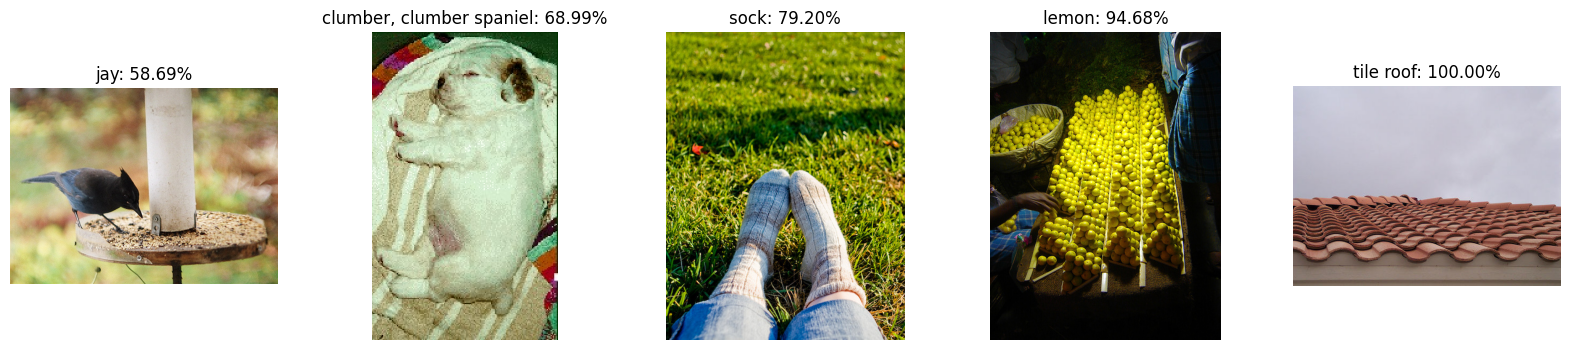

In [33]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import clip
import matplotlib.pyplot as plt
from PIL import Image

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

# Define a list of image paths from ImageNet (replace these with actual ImageNet image paths)
image_paths = [
    "imagenetvariety/n01580077_jay.JPEG",  # Replace with actual paths to ImageNet images
    "imagenetvariety/n02101556_clumber, clumber spaniel.JPEG",
    "imagenetvariety/n04254777_sock.JPEG",
    "imagenetvariety/n07749582_lemon.JPEG",
    "imagenetvariety/n04435653_tile roof.JPEG"
]

# Load and preprocess the images
images = [preprocess(Image.open(path)).unsqueeze(0) for path in image_paths]

# Concatenate all images into a single tensor
images_tensor = torch.cat(images).to(device)

# Define some text prompts corresponding to common ImageNet classes
text_prompts = list(label_map[val] for val in image_net_labels_array)

# Prepare the text tokens
text_tokens = clip.tokenize(text_prompts).to(device)

# Calculate image and text features
with torch.no_grad():
    image_features = model.encode_image(images_tensor)
    text_features = model.encode_text(text_tokens)

# Calculate similarity and get predictions
logits_per_image, _ = model(images_tensor, text_tokens)
probs = logits_per_image.softmax(dim=-1)
top_probs, top_labels = probs.max(dim=-1)

# Plotting the images with the most likely class label
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, img in enumerate(images):
    axs[i].imshow(Image.open(image_paths[i]))
    prediction_text = f'{text_prompts[top_labels[i]]}: {top_probs[i].item()*100:.2f}%'
    axs[i].set_title(prediction_text)
    axs[i].axis('off')

plt.show()

#### CLIP vs ImageNet pretraining

In [35]:
def get_predictions_resnet50(image_path):
    input_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = resnet50(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    return [(classes[catid], prob.item()) for catid, prob in zip(top5_catid, top5_prob)]

In [36]:
def get_predictions_clip(image_path):
    image = preprocess_clip(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits_per_image, _ = clip_model(image, clip.tokenize(["a photo"] * image.size(0)).to(device))
    probabilities = logits_per_image.softmax(dim=-1)
    return probabilities.squeeze().item()

In [1]:
# Load the models
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = models.resnet50(pretrained=True).to(device)
resnet50.eval()

clip_model, preprocess_clip = clip.load("RN50", device=device)

# Define the ImageNet class index to labels
with open("imagenet_labels.txt") as f:
    classes = [line.strip() for line in f.readlines()]


# Plotting images and predictions
def plot_images_with_predictions(folder_paths):
    fig, axs = plt.subplots(len(folder_paths), 3, figsize=(15, 5 * len(folder_paths)))
    for idx, folder in enumerate(folder_paths):
        images = [os.path.join(folder, img) for img in sorted(os.listdir(folder))[:3]]
        for jdx, img_path in enumerate(images):
            img = Image.open(img_path)
            axs[idx, jdx].imshow(img)
            axs[idx, jdx].axis('off')
            resnet_predictions = get_predictions_resnet50(img_path)
            clip_probability = get_predictions_clip(img_path)
            axs[idx, jdx].set_title(f"ResNet-50 Top-1: {resnet_predictions[0][0]}\nCLIP Prob: {clip_probability:.4f}")
    plt.tight_layout()
    plt.show()

NameError: name 'torch' is not defined

#### FP16

In [4]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import clip
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device)

for name, param in clip_model.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")

Layer: positional_embedding, precision: torch.float32
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float32
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float32
Layer: visual.bn1.bias, precision: torch.float32
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float32
Layer: visual.bn2.bias, precision: torch.float32
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float32
Layer: visual.bn3.bias, precision: torch.float32
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float32
Layer: visual.layer1.0.bn1.bias, precision: torch.float32
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float32
Layer: visual.layer1.0.bn2.bias, precision: torch.float32
Layer: visual.layer1.0.conv3.weig

In [5]:
clip_model, preprocess = clip.load("RN50", device=device)

# converting all the model params to fp16
clip_model = clip_model.half()
clip_model = clip_model.to(device)

for name, param in clip_model.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")

Layer: positional_embedding, precision: torch.float16
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float16
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float16
Layer: visual.bn1.bias, precision: torch.float16
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float16
Layer: visual.bn2.bias, precision: torch.float16
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float16
Layer: visual.bn3.bias, precision: torch.float16
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.bias, precision: torch.float16
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.bias, precision: torch.float16
Layer: visual.layer1.0.conv3.weig

### Comparing wall clock time to encode image between the fp16 and original (mixed) model

In [6]:
import time
import torch.cuda.amp as amp

image_path = "imagenetvariety/n04435653_tile roof.JPEG"
try_image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
try_image = try_image.half()
scaler = amp.GradScaler()
avg_time = 0.0

with torch.no_grad():    
    with amp.autocast(enabled=True):
        for i in range(100):
            stime = time.time()
            clip_model.encode_image(try_image)
            etime = time.time()
            avg_time += (etime - stime)
        
avg_time /= 100
print("Average time taken with fp16:", avg_time, "seconds")

Average time taken with fp16: 0.04938548803329468 seconds


In [1]:
import torch
import clip
from PIL import Image


model, preprocess = clip.load('RN50', "cuda")  # Convert to FP32

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
import time

image_path = "imagenetvariety/n04435653_tile roof.JPEG"
try_image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
avg_time = 0.0

with torch.no_grad():    
    for i in range(100):
        stime = time.time()
        clip_model.encode_image(try_image)
        etime = time.time()
        avg_time += (etime - stime)
        
avg_time /= 100
print("Average time taken with the original mixed precision model:", avg_time, "seconds")

Average time taken with the original mixed precision model: 0.02204538345336914 seconds


In [45]:
model_fp32, _ = clip.load('RN50', device)
model_fp32.eval()
model.eval()

differences = []
with torch.no_grad():
    for image in images:
        output_fp32 = model_fp32.encode_image(image.float())  # Ensure the image is in FP32 for this model
        output_fp16 = model.encode_image(image)
        differences.append(torch.norm(output_fp32 - output_fp16.float()).item())  # Convert FP16 output back to FP32 for comparison

print("Differences in output vectors:", differences)

Differences in output vectors: [0.02080550603568554, 0.013225354254245758, 0.008718853816390038, 0.00979978684335947, 0.008956718258559704]


### Difference in output of FP16 and mixed precision model

In [1]:
classes_dict = {}

with open("imagenetCLS.txt", "r") as f:
    read_file = f.read()
    labels = read_file.split("\n")
print(labels)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

In [6]:
image_paths = ["imagenetvariety/n01580077_jay.JPEG"]

device= "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device)
tokens = clip.tokenize(labels).to(device)

In [4]:
image = preprocess(Image.open(image_paths[0])).unsqueeze(0).to(device)

In [5]:
logits, logits_text = clip_model(image, tokens)
prob_scores = logits.softmax(dim=-1).detach().cpu().numpy()
print(f"probability scores (MIXED/FP32): {prob_scores}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 76.00 MiB (GPU 0; 15.70 GiB total capacity; 12.68 GiB already allocated; 14.38 MiB free; 13.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
device= "cuda" if torch.cuda.is_available() else "cpu"
for image_path in image_paths:
        clip_model_fp16, preprocess = clip.load("RN50", device=device)
        clip_model_fp16 = clip_model_fp16.half()
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        image = image.half()
        tokens = clip.tokenize(labels).to(device).long()
        tokens = tokens.half()
        logits, logits_text = clip_model_fp16(image, tokens)
        prob_scores = logits.softmax(dim=-1).detach().cpu().numpy()
        print(f"probability scores (FP 16): {prob_scores}")

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.HalfTensor instead (while checking arguments for embedding)

In [12]:
# FP16
import time
import torch.cuda.amp as amp

image_path = "imagenetvariety/n01580077_jay.JPEG"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image = image.half()

clip_model, preprocess = clip.load("RN50", device=device)
clip_model = clip_model.half()
clip_model = clip_model.to(device)

with amp.autocast(enabled=True):
    torch.cuda.memory._record_memory_history(enabled=True)
    start = torch.cuda.memory_summary()
    clip_model.encode_image(image)
    print(f"Memory usage with FP16 input: {torch.cuda.memory_allocated(device)} bytes")
    print()
    end = torch.cuda.memory_summary()
    torch.cuda.memory._record_memory_history(enabled=True)
    print("Memory summary at the start")
    print(start)
    print("Memory summary at the end")
    print(end)

Memory usage with FP16 input: 670654976 bytes

Memory summary at the start
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  654936 KB |     978 MB |    2670 MB |    2031 MB |
|       from large pool |  598016 KB |     870 MB |    2453 MB |    1869 MB |
|       from small pool |   56920 KB |     108 MB |     217 MB |     161 MB |
|---------------------------------------------------------------------------|
| Active memory         |  654936 KB |     978 MB |    2670 MB |   

In [2]:
import time
import torch.cuda.amp as amp

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

image_path = "imagenetvariety/n01580077_jay.JPEG"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image = image.half()

clip_model, preprocess = clip.load("RN50", device=device)
clip_model = clip_model.to(device)

with amp.autocast(enabled=True):
    torch.cuda.memory._record_memory_history(enabled=True)
    start = torch.cuda.memory_summary()
    clip_model.encode_image(image)
    print(f"Memory usage with FP16 input: {torch.cuda.memory_allocated(device)} bytes")
    print()
    end = torch.cuda.memory_summary()
    torch.cuda.memory._record_memory_history(enabled=True)
    print("Memory summary at the start")
    print(start)
    print("Memory summary at the end")
    print(end)

Memory usage with FP16 input: 513001472 bytes

Memory summary at the start
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  500978 KB |  500978 KB |  501566 KB |  602112 B  |
|       from large pool |  462336 KB |  462336 KB |  462336 KB |       0 B  |
|       from small pool |   38642 KB |   38642 KB |   39230 KB |  602112 B  |
|---------------------------------------------------------------------------|
| Active memory         |  500978 KB |  500978 KB |  501566 KB |  6

### FP 32 - 670654976 bytes
### FP 16 - 513001472 bytes

FP 16 uses less memory